## Evaluating the Best Logistic Regression Model


During the last sprint, I developed a baseline logistic regression model that achieved an accuracy rate of 94.73%. While evaluating whether a linear regression or logistic regression approach would be more appropriate, I encountered an issue related to an imbalanced dataset for the target variable. This variable represents whether a tissue sample's toxicity level exceeds the safety threshold.

To address this issue, I revisited the treatment of null values in the "Result" column. Rather than arbitrarily imputing nulls with 0s—which implied the chemical was not detected—I redefined their meaning. Null values were instead dropped, as they now represent cases where results were not recorded.

Further evaluation of the model includes metrics such as train-test splits, precision, recall, F1 score, and the ROC-AUC curve. Additionally, I am testing the model with various random states during data splitting to identify the configuration that yields the best performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Only run this when using google.colab

# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# loading the dataset

file_path = '/content/drive/MyDrive/Colab Notebooks/PCB_df_v2.csv' #use this command if using Google Colab
PCB_df = pd.read_csv(file_path, low_memory=False, index_col=0)

#PCB_df = pd.read_csv('PCB_df.csv', low_memory=False, index_col=0) #use this command if running in Jupyter Notebook



In [4]:
PCB_df.drop_duplicates(inplace=True) #Dropping the duplicates since models does not do well with these

## Base Model Evaluation



In [5]:
X_log = PCB_df.drop('PCB_threshold', axis=1)
y_log = PCB_df['PCB_threshold'].copy()

In [6]:
y_log.value_counts()

,count
PCB_threshold,
0,36827
1,3436


### Detecting Collinearity

First I am using the .corr function and heatmaps to remove the features showing the highest level of collinearity

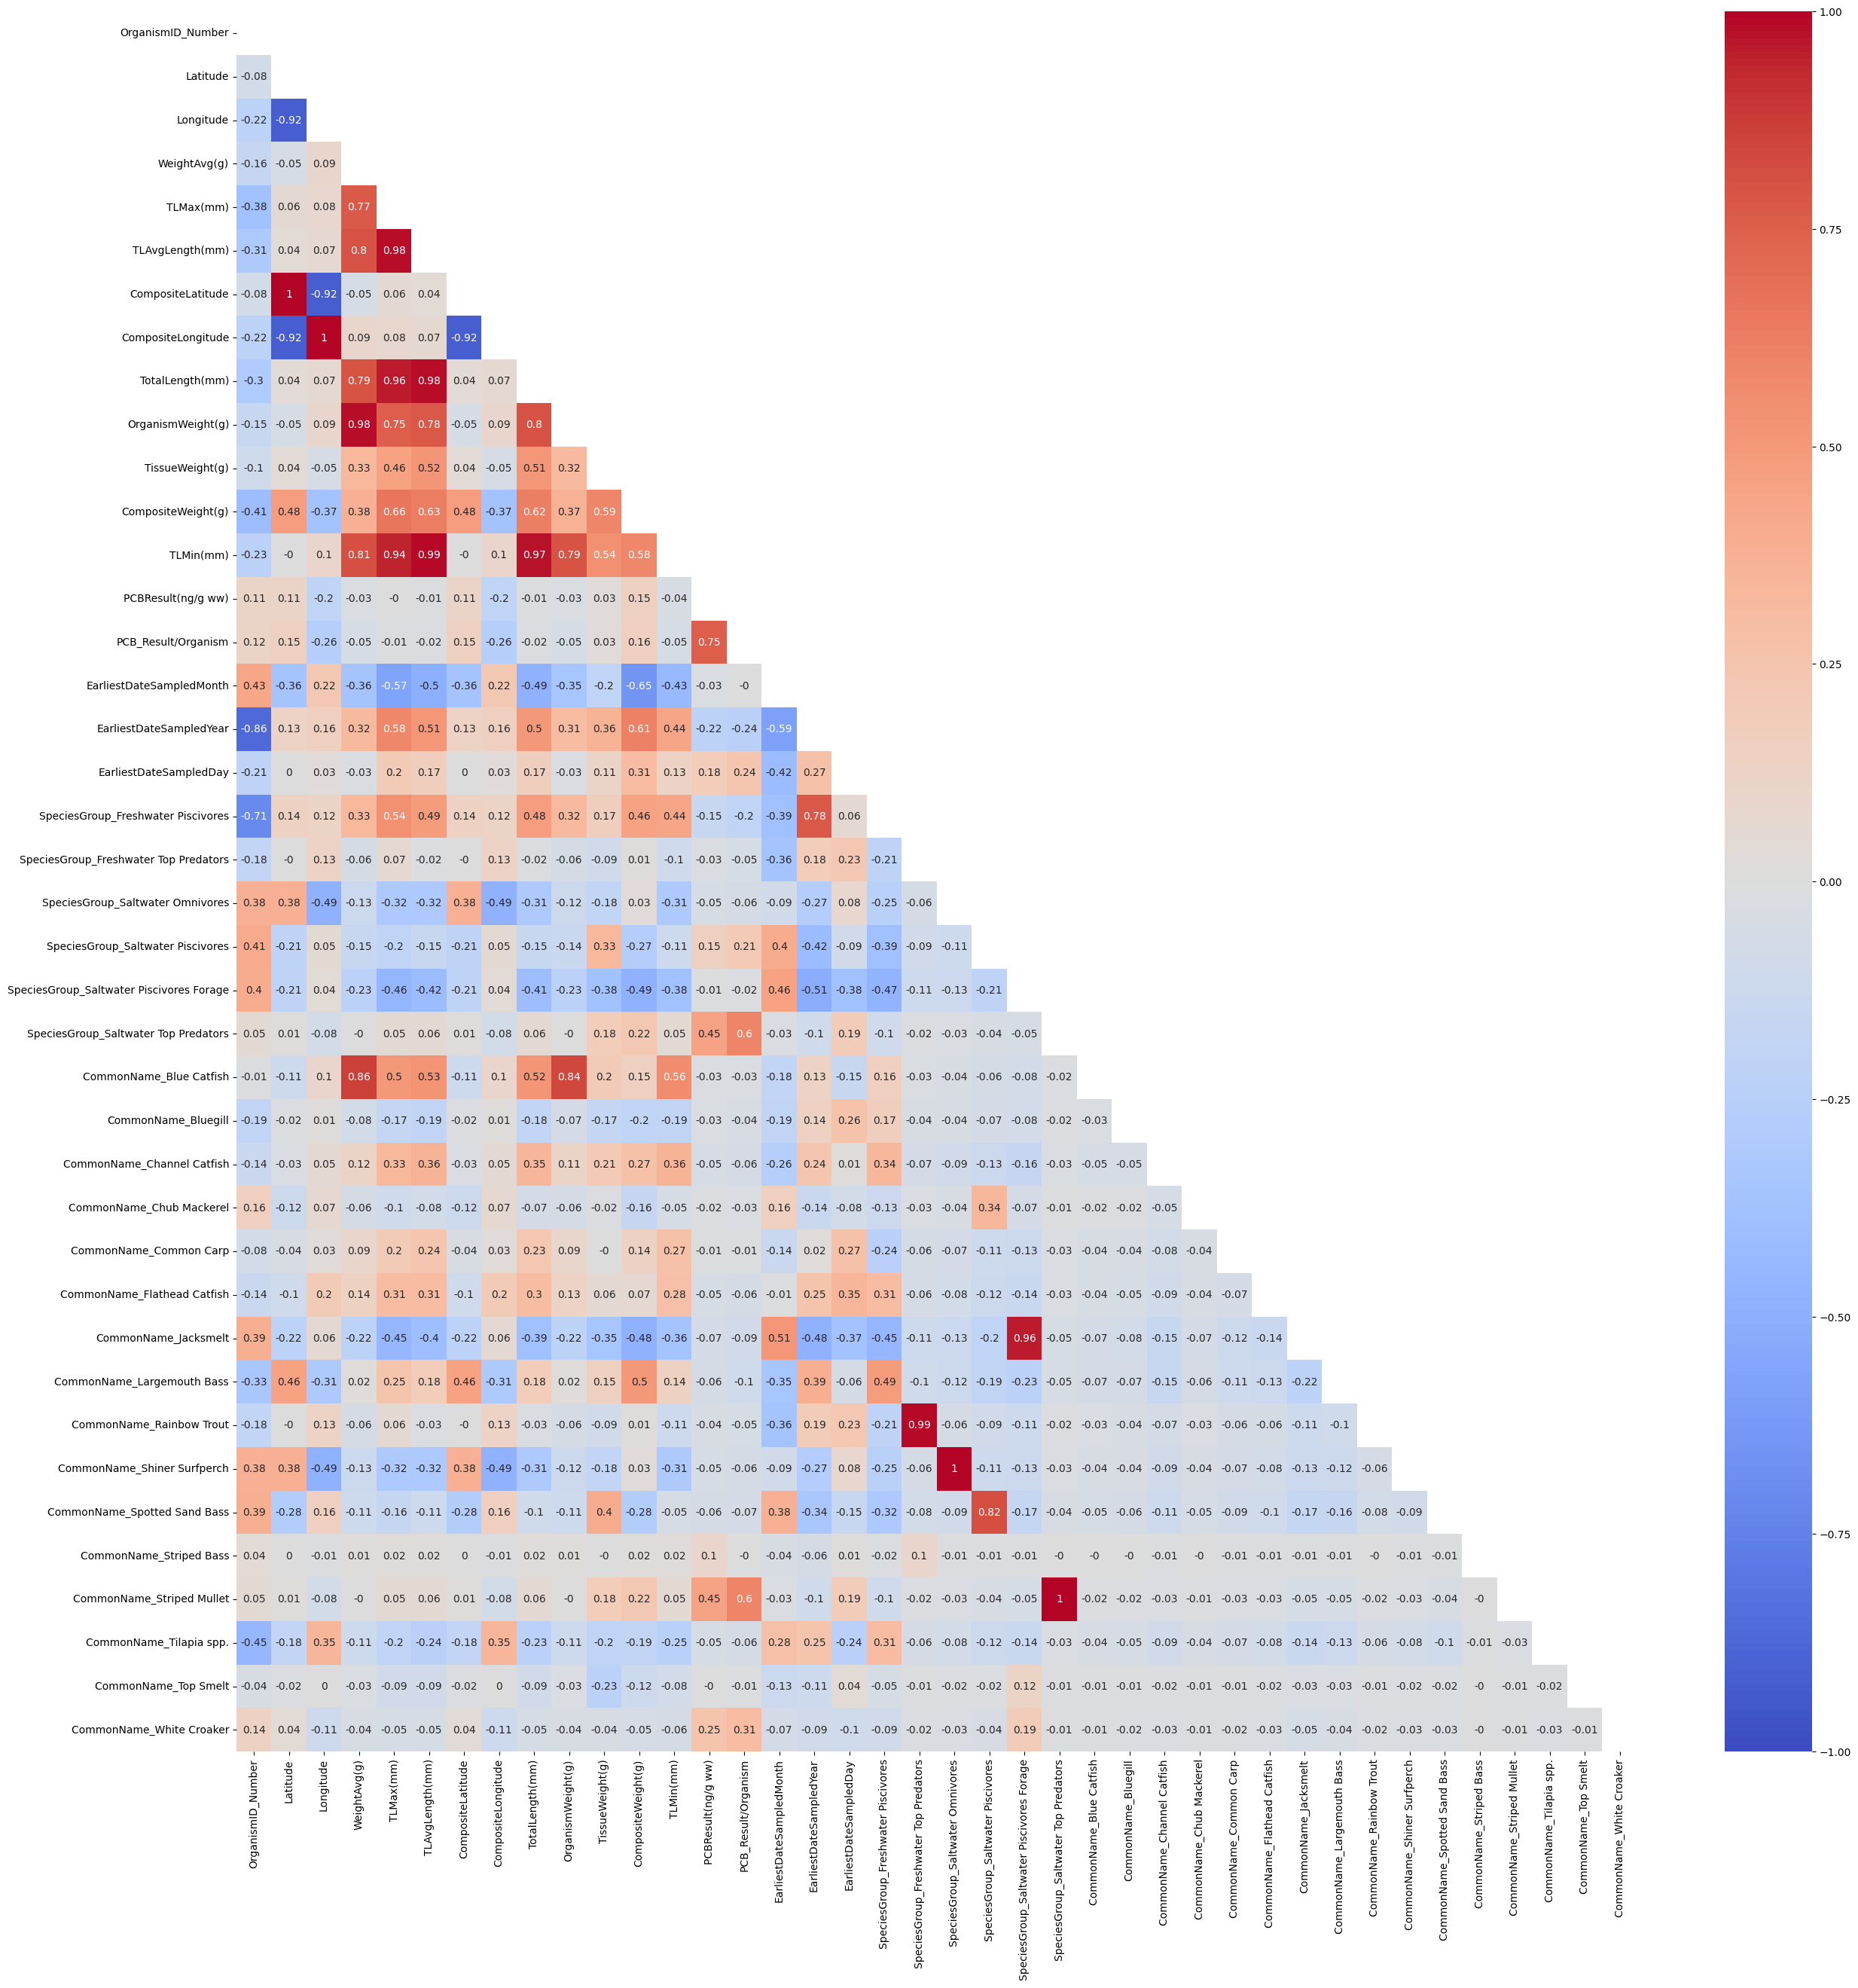

In [7]:
# Calculate all the correlations between each independent variable
corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

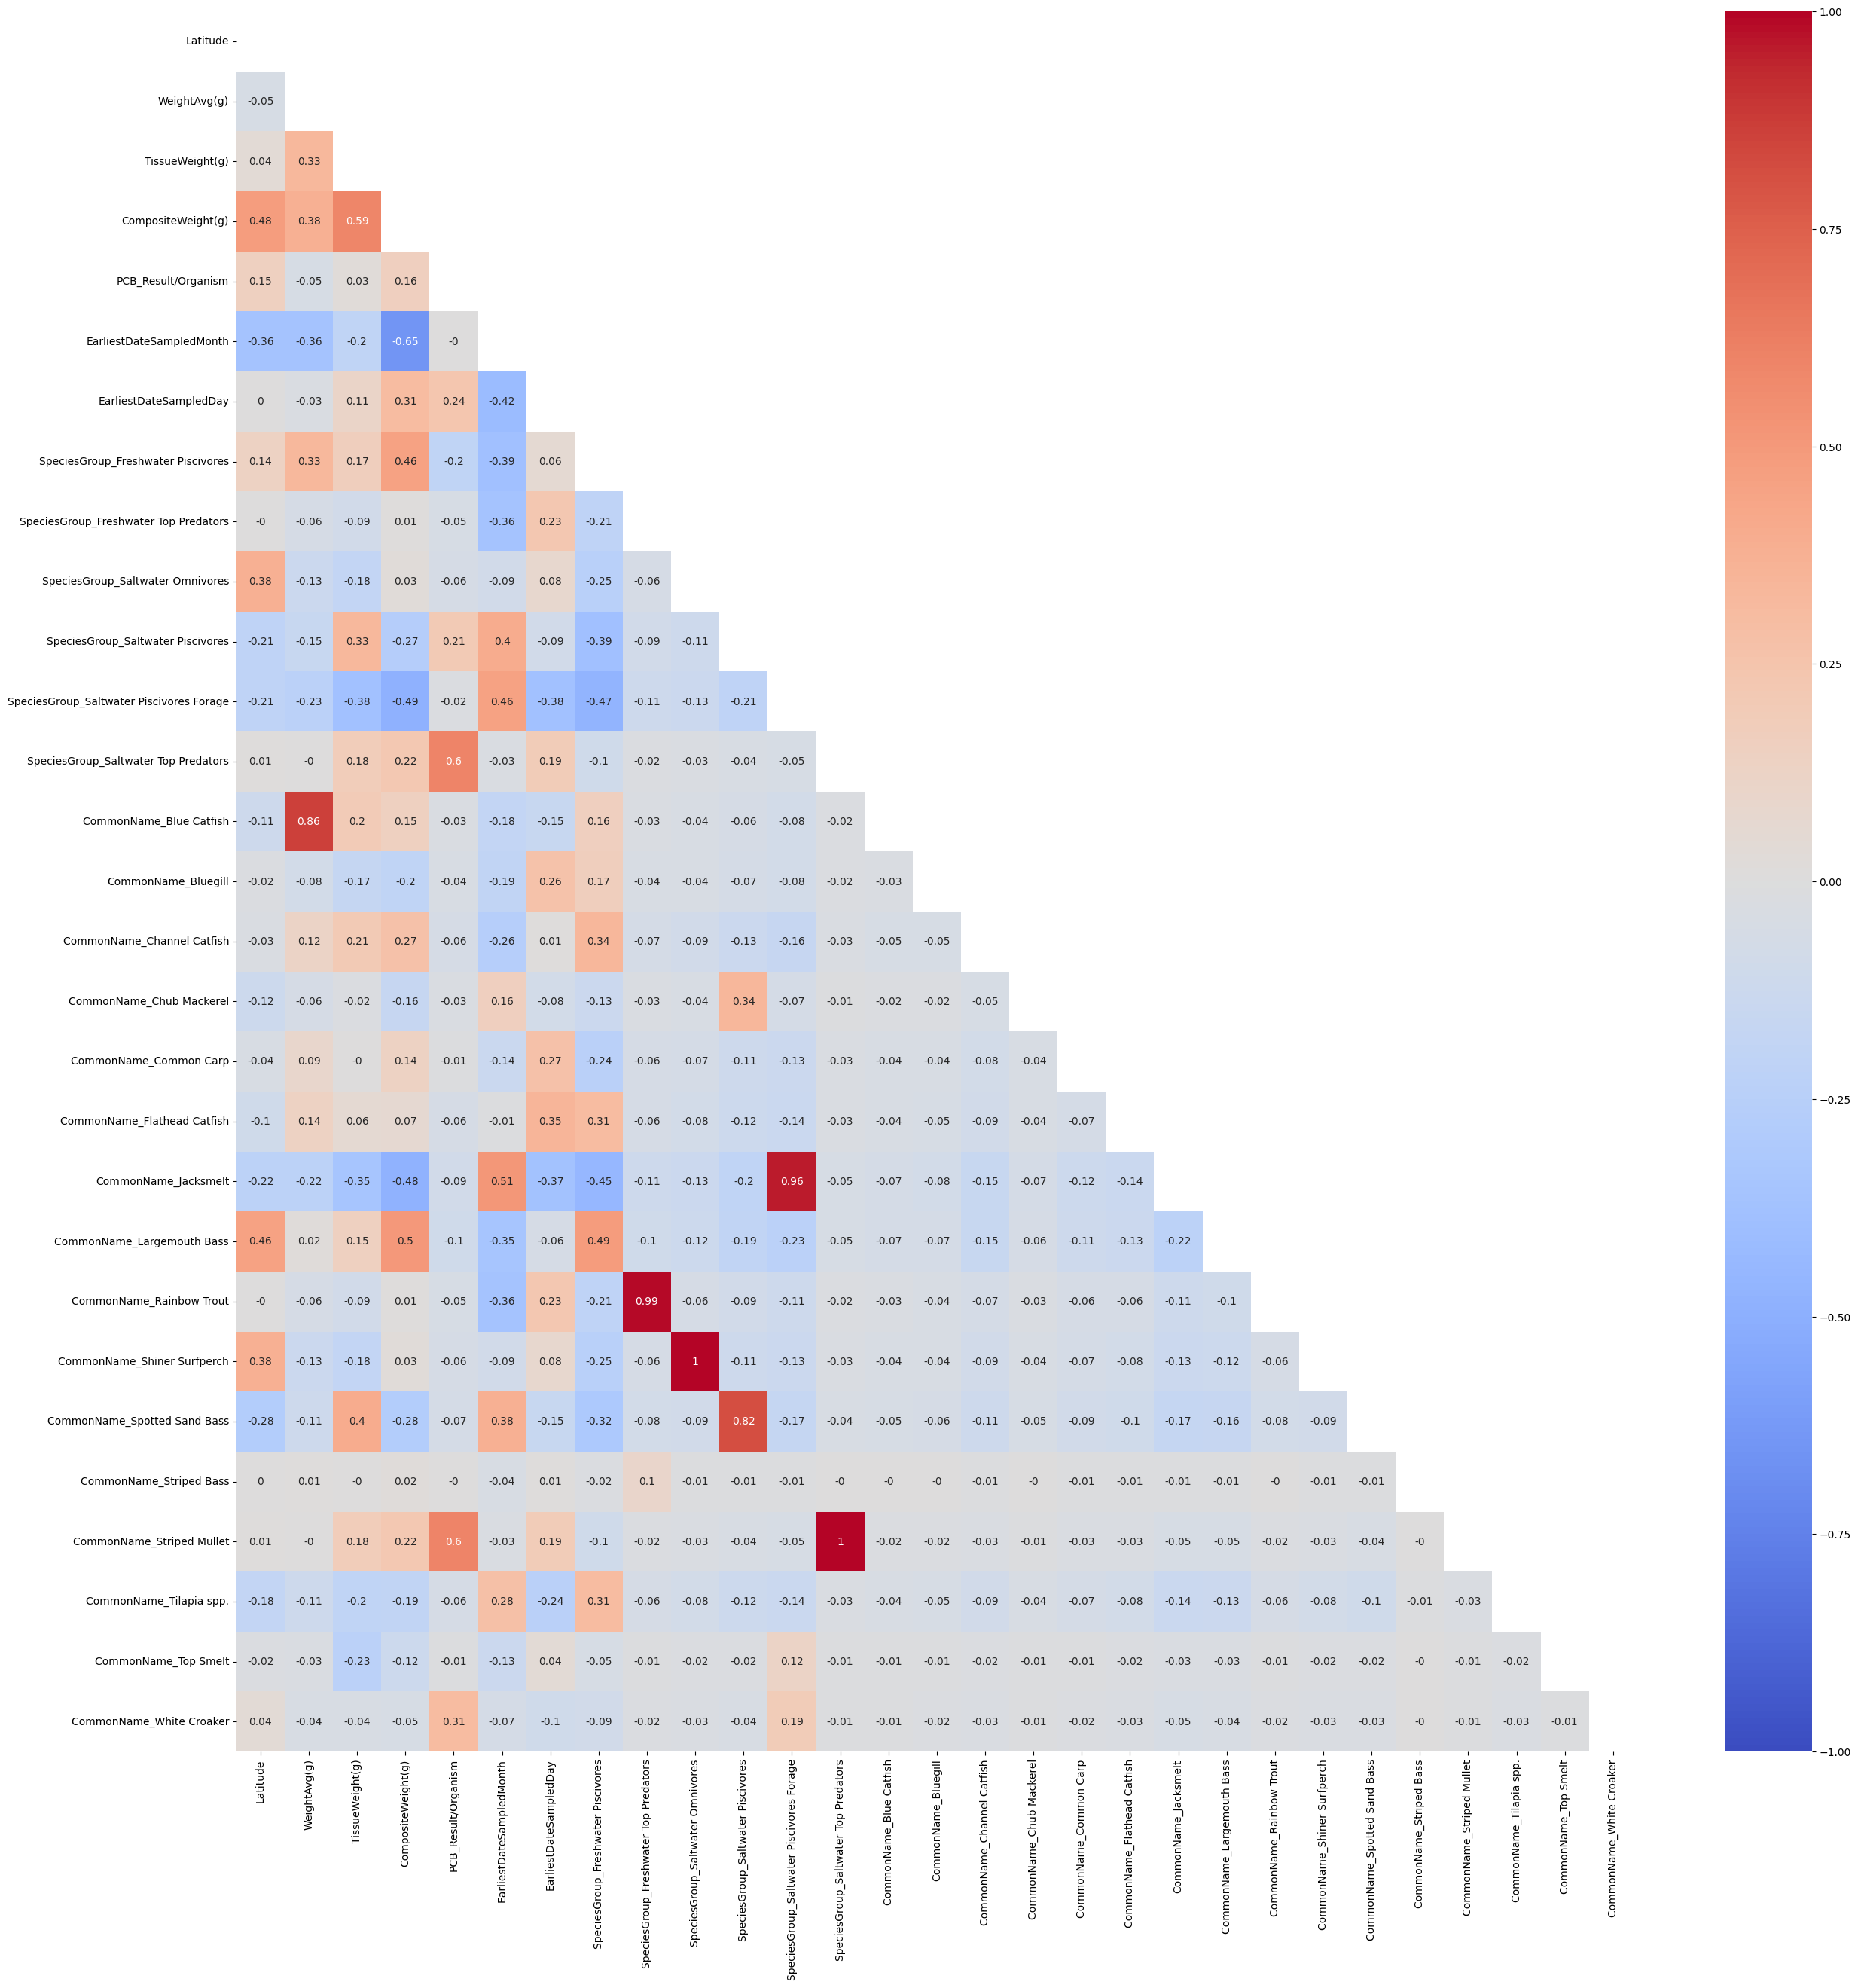

In [8]:
X_log_drop_col = ['Longitude', 'TLMax(mm)', 'TLAvgLength(mm)',
       'CompositeLatitude','CompositeLongitude','TotalLength(mm)',
       'OrganismWeight(g)',
       'TLMin(mm)', 'PCBResult(ng/g ww)',
       'OrganismID_Number', 'EarliestDateSampledYear'
       ]
X_log.drop(columns=X_log_drop_col, inplace=True)

corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

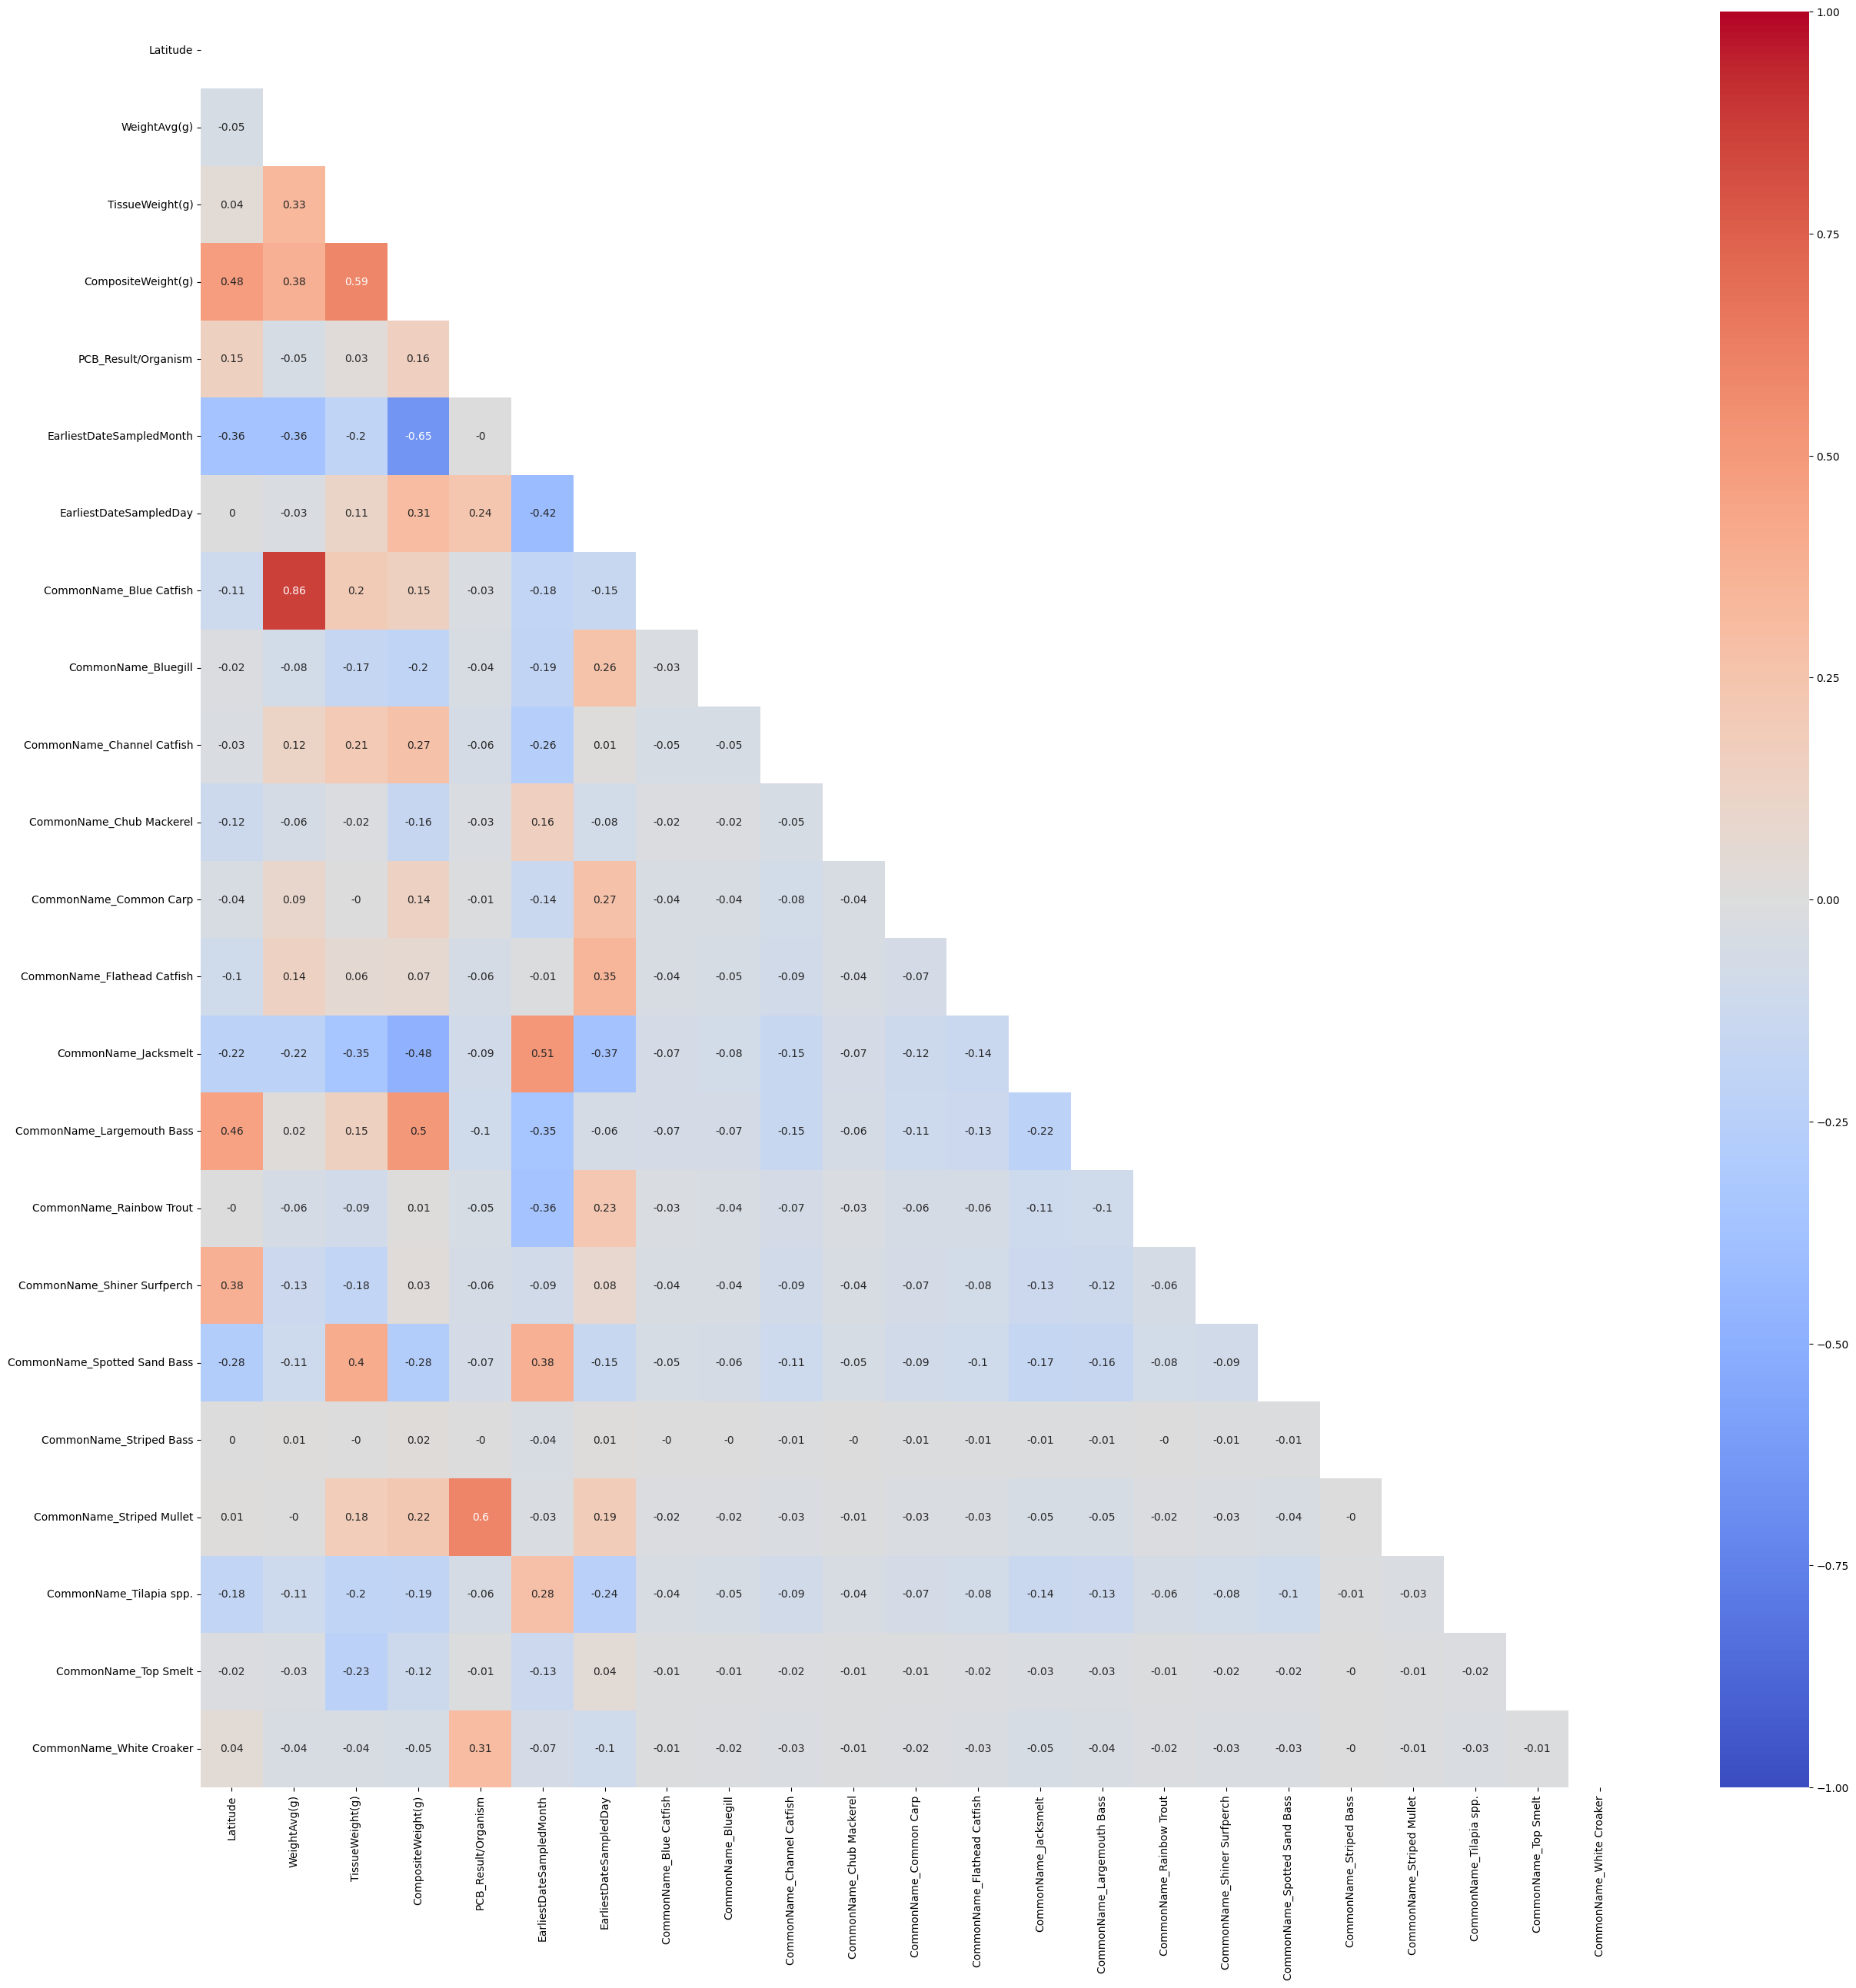

In [9]:

columns_with_speciesgroup = [col for col in X_log.columns if 'SpeciesGroup' in col]


X_log.drop(columns=columns_with_speciesgroup, inplace=True)

# Calculate all the correlations between each independent variable
corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

## Detecting Multicolinearity with VIF Values

Previously, I have set the threshold to 5. However, as I want to keep as many species features as possible, I have updated the threshold to 10. In addition, after looking further into how unbalanced my class 0 & 1 distribution is

In [10]:
X3 = X_log.copy()
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.977871
WeightAvg(g),8.459994
TissueWeight(g),6.772720
CompositeWeight(g),12.118969
PCB_Result/Organism,11.466855
EarliestDateSampledMonth,8.380820
EarliestDateSampledDay,3.579646
CommonName_Blue Catfish,12.543376
CommonName_Bluegill,8.593318
CommonName_Channel Catfish,20.433239


In [11]:
X3.drop(columns=['WeightAvg(g)'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.974290
TissueWeight(g),6.772569
CompositeWeight(g),12.015738
PCB_Result/Organism,11.354110
EarliestDateSampledMonth,7.917712
EarliestDateSampledDay,3.421213
CommonName_Blue Catfish,6.151813
CommonName_Bluegill,8.574983
CommonName_Channel Catfish,20.008269
CommonName_Chub Mackerel,6.273633


In [12]:
X3.drop(columns=['TissueWeight(g)'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.958444
CompositeWeight(g),5.788121
PCB_Result/Organism,10.969354
EarliestDateSampledMonth,7.534850
EarliestDateSampledDay,3.286926
CommonName_Blue Catfish,6.149615
CommonName_Bluegill,8.544323
CommonName_Channel Catfish,19.903509
CommonName_Chub Mackerel,6.073219
CommonName_Common Carp,13.324022


In [13]:
X3.drop(columns=['CompositeWeight(g)'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.462160
PCB_Result/Organism,10.430675
EarliestDateSampledMonth,6.417266
EarliestDateSampledDay,2.976018
CommonName_Blue Catfish,6.122327
CommonName_Bluegill,6.810568
CommonName_Channel Catfish,19.547476
CommonName_Chub Mackerel,5.761324
CommonName_Common Carp,12.854385
CommonName_Flathead Catfish,17.346619


In [14]:
X3.drop(columns=['EarliestDateSampledDay'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.131032
PCB_Result/Organism,9.871012
EarliestDateSampledMonth,6.397679
CommonName_Blue Catfish,6.065670
CommonName_Bluegill,6.561128
CommonName_Channel Catfish,19.528299
CommonName_Chub Mackerel,5.751541
CommonName_Common Carp,12.584420
CommonName_Flathead Catfish,16.902358
CommonName_Jacksmelt,37.535328


In [15]:
X3.drop(columns=['EarliestDateSampledMonth'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.126019
PCB_Result/Organism,9.648891
CommonName_Blue Catfish,6.033880
CommonName_Bluegill,6.523602
CommonName_Channel Catfish,19.517955
CommonName_Chub Mackerel,5.342683
CommonName_Common Carp,12.580381
CommonName_Flathead Catfish,16.698674
CommonName_Jacksmelt,34.562945
CommonName_Largemouth Bass,32.255766


In [16]:
# I am dropping this even though the VIF is low since this is another target variable for the other model

X3.drop(columns=['PCB_Result/Organism'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant


,0
Latitude,2.120541
CommonName_Blue Catfish,2.087641
CommonName_Bluegill,2.098734
CommonName_Channel Catfish,4.717981
CommonName_Chub Mackerel,1.950171
CommonName_Common Carp,3.474574
CommonName_Flathead Catfish,4.217513
CommonName_Jacksmelt,8.019247
CommonName_Largemouth Bass,6.729904
CommonName_Rainbow Trout,2.920137


### Fitting The Logistic Model

Model 1

In [17]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X3, y_log, test_size=0.2, random_state=17)

#fitting the model with backward selection

# 0. ADD THAT CONSTANT
X_const3 = sm.add_constant(X3)


# 1. Instatiate the model
PCB_log= sm.Logit(y_train, X_train)

# Fit the model with L1 regularization
PCB_log_fitted = PCB_log.fit_regularized(method='l1', alpha= 0.1)
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_log_fitted.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14211374688710046
            Iterations: 231
            Function evaluations: 239
            Gradient evaluations: 231


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 17 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          PCB_threshold   No. Observations:                32210
Model:                          Logit   Df Residuals:                    32193
Method:                           MLE   Df Model:                           16
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                  0.5176
Time:                        02:13:09   Log-Likelihood:                -4564.4
converged:                       True   LL-Null:                       -9462.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Latitude                         0.0598      0.003     18.799      0.000       0.054       0.066
CommonName_Blue Catfish        -11.2249      3.685     -3.046      0.002     -18.448      -4.002
CommonName_Bluegill            -11.3915      3.746     -3.041      0.002     -18.734      -4.049
CommonName_Channel Catfish      -5.5280      0.153    -36.130      0.000      -5.828      -5.228
CommonName_Chub Mackerel       -11.1128      3.910     -2.842      0.004     -18.775      -3.450
CommonName_Common Carp          -3.3696      0.122    -27.703      0.000      -3.608      -3.131
CommonName_Flathead Catfish    -12.1602      3.219     -3.777      0.000     -18.470      -5.851
CommonName_Jacksmelt            -3.9322      0.114    -34.624      0.000      -4.155      -3.710
CommonName_Largemouth Bass      -7.9500      0.268    -29.626      0.000      -8.476      -7.424
CommonName_Rainbow Trout       -11.3154      2.656     -4.260      0.000     -16.522      -6.109
CommonName_Shiner Surfperch    -11.7220      2.508     -4.674      0.000     -16.638      -6.806
CommonName_Spotted Sand Bass    -5.4489      0.145    -37.508      0.000      -5.734      -5.164
CommonName_Striped Bass          3.1904      3.389      0.941      0.347      -3.452       9.833
CommonName_Striped Mullet        8.9690     13.452      0.667      0.505     -17.397      35.335
CommonName_Tilapia spp.        -12.1121      3.220     -3.761      0.000     -18.424      -5.801
CommonName_Top Smelt            -3.2821      0.259    -12.685      0.000      -3.789      -2.775
CommonName_White Croaker         7.5750      7.440      1.018      0.309      -7.007      22.157
================================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Both 'CommonName_Striped Mullet', 'CommonName_Striped Bass' needs to be dropped since they have very high p-values


In [18]:
X3.drop(columns=['CommonName_Striped Mullet', 'CommonName_Striped Bass'], inplace=True)



In [19]:
X_train, X_test, y_train, y_test = train_test_split(X3, y_log, test_size=0.2, random_state=17)


# 0. ADD THAT CONSTANT
X_const3 = sm.add_constant(X3)


# 1. Instatiate the model
PCB_log= sm.Logit(y_train, X_train)

# Fit the model with L1 regularization
PCB_log_fitted = PCB_log.fit_regularized(method='l1', alpha= 0.1)
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_log_fitted.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14317505351912915
            Iterations: 216
            Function evaluations: 222
            Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          PCB_threshold   No. Observations:                32210
Model:                          Logit   Df Residuals:                    32195
Method:                           MLE   Df Model:                           14
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                  0.5140
Time:                        02:13:10   Log-Likelihood:                -4599.0
converged:                       True   LL-Null:                       -9462.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Latitude                         0.0713      0.003     22.700      0.000       0.065       0.077
CommonName_Blue Catfish        -11.9453      4.370     -2.734      0.006     -20.510      -3.381
CommonName_Bluegill            -12.2382      4.698     -2.605      0.009     -21.446      -3.030
CommonName_Channel Catfish      -5.9218      0.152    -38.933      0.000      -6.220      -5.624
CommonName_Chub Mackerel       -12.0524      5.178     -2.328      0.020     -22.201      -1.904
CommonName_Common Carp          -3.7617      0.120    -31.224      0.000      -3.998      -3.526
CommonName_Flathead Catfish    -12.2171      2.729     -4.477      0.000     -17.566      -6.868
CommonName_Jacksmelt            -4.3195      0.112    -38.410      0.000      -4.540      -4.099
CommonName_Largemouth Bass      -8.3809      0.269    -31.184      0.000      -8.908      -7.854
CommonName_Rainbow Trout       -11.6028      2.517     -4.609      0.000     -16.537      -6.669
CommonName_Shiner Surfperch    -12.1994      2.570     -4.747      0.000     -17.237      -7.162
CommonName_Spotted Sand Bass    -5.8259      0.144    -40.353      0.000      -6.109      -5.543
CommonName_Tilapia spp.        -12.2129      2.799     -4.363      0.000     -17.700      -6.726
CommonName_Top Smelt            -3.6705      0.258    -14.220      0.000      -4.176      -3.165
CommonName_White Croaker         9.6948     26.293      0.369      0.712     -41.838      61.227
================================================================================================

Possibly complete quasi-separation: A fraction 0.30 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [20]:
X3.drop(columns=['CommonName_White Croaker'], inplace=True)


In [21]:
# 1. Fitting the final model after dropping everything that has a p_value > 0.05

X_train, X_test, y_train, y_test = train_test_split(X3, y_log, test_size=0.2, random_state=17)


# 0. ADD THAT CONSTANT
X_const3 = sm.add_constant(X3)


# 1. Instatiate the model
PCB_log= sm.Logit(y_train, X_train)

# Fit the model with L1 regularization
PCB_log_fitted = PCB_log.fit_regularized(method='l1', alpha= 0.1)
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_log_fitted.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14376713733036417
            Iterations: 211
            Function evaluations: 217
            Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 14 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          PCB_threshold   No. Observations:                32210
Model:                          Logit   Df Residuals:                    32196
Method:                           MLE   Df Model:                           13
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                  0.5119
Time:                        02:13:11   Log-Likelihood:                -4618.8
converged:                       True   LL-Null:                       -9462.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Latitude                         0.0781      0.003     25.035      0.000       0.072       0.084
CommonName_Blue Catfish        -11.9342      3.890     -3.068      0.002     -19.559      -4.309
CommonName_Bluegill            -11.9980      3.715     -3.230      0.001     -19.279      -4.717
CommonName_Channel Catfish      -6.1536      0.152    -40.592      0.000      -6.451      -5.856
CommonName_Chub Mackerel       -11.5755      3.655     -3.167      0.002     -18.739      -4.412
CommonName_Common Carp          -3.9908      0.120    -33.326      0.000      -4.225      -3.756
CommonName_Flathead Catfish    -12.9355      3.489     -3.707      0.000     -19.774      -6.097
CommonName_Jacksmelt            -4.5460      0.112    -40.675      0.000      -4.765      -4.327
CommonName_Largemouth Bass      -8.6270      0.268    -32.150      0.000      -9.153      -8.101
CommonName_Rainbow Trout       -12.0158      2.757     -4.358      0.000     -17.420      -6.612
CommonName_Shiner Surfperch    -12.5677      2.726     -4.610      0.000     -17.911      -7.225
CommonName_Spotted Sand Bass    -6.0463      0.144    -42.040      0.000      -6.328      -5.764
CommonName_Tilapia spp.        -12.4629      2.838     -4.392      0.000     -18.024      -6.901
CommonName_Top Smelt            -3.8994      0.258    -15.121      0.000      -4.405      -3.394
================================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [22]:
# 2. Score on the training data
from sklearn.metrics import accuracy_score

# Calculate predictions for training data
y_train_pred = PCB_log_fitted.predict(X_train)
y_train_pred_binary = (y_train_pred >= 0.5).astype(int)  # Convert to binary predictions

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)

print(f"Training accuracy: {train_accuracy}")

# 3. Score on the testing data
# Calculate predictions for test data
y_test_pred = PCB_log_fitted.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)  # Convert to binary predictions

# Calculate accuracy for test data
test_accuracy = accuracy_score(y_test, y_test_pred_binary)

print(f"Testing accuracy: {test_accuracy}")




Training accuracy: 0.954796647004036
Testing accuracy: 0.9549236309449894


The performance of the model slightly improved from the Sprint 2 base model. The testing scare is also slighly higher than the training score, indicating that the performance is pretty good.... So far...



## Looking at Coeficients


Mullet still shows the highest positive correlation

In [23]:
PCB_log_fitted.pvalues.sort_values()

,0
CommonName_Channel Catfish,0.000000e+00
CommonName_Jacksmelt,0.000000e+00
CommonName_Spotted Sand Bass,0.000000e+00
CommonName_Common Carp,1.635512e-243
CommonName_Largemouth Bass,8.778579e-227
Latitude,2.541639e-138
CommonName_Top Smelt,1.175480e-51
CommonName_Shiner Surfperch,4.023749e-06
CommonName_Tilapia spp.,1.122741e-05
CommonName_Rainbow Trout,1.311377e-05


Tissue Weight and Latitude has the highest P-values, meaning they are more likely to be randomly related to the y-value

In [24]:
coefficients_df = pd.DataFrame({'coeff': PCB_log_fitted.params,
                               'p_values': PCB_log_fitted.pvalues})

coefficients_df.reset_index(inplace=True)

coefficients_df.rename({'index': 'variable'}, axis='columns', inplace=True)
coefficients_df

,variable,coeff,p_values
0,Latitude,0.078072,2.541639e-138
1,CommonName_Blue Catfish,-11.934226,2.157012e-03
2,CommonName_Bluegill,-11.997977,1.239845e-03
3,CommonName_Channel Catfish,-6.153565,0.000000e+00
4,CommonName_Chub Mackerel,-11.575520,1.539306e-03
5,CommonName_Common Carp,-3.990762,1.635512e-243
6,CommonName_Flathead Catfish,-12.935468,2.093974e-04
7,CommonName_Jacksmelt,-4.545965,0.000000e+00
8,CommonName_Largemouth Bass,-8.627018,8.778579e-227
9,CommonName_Rainbow Trout,-12.015809,1.311377e-05


Another visual to see how each of these independent variables shows an odd of either increasing or decreasing


In [25]:
categories = [] # Hold labels for bar
size = [] # Hold bar heights
colors = [] # Hold bar colors
p_values = [] # Used for additional text within the plot

p_value_color_scale = 1.5

# iterate through
for index, row in coefficients_df.iterrows():
    variable_name = row['variable'].strip()

    if (variable_name != 'const'): # We don't care much for the constant since we can modify it
        categories.append(variable_name)
        coefficients_value = row['coeff']

        p_value = round(row['p_values'], 2)
        p_values.append(p_value)

        color = [1.0, 1.0, 1.0]

        color[1] = (min(p_value_color_scale*p_value, 1.0)/1.0) # Make GREEN brighters
        if (coefficients_value >= 0):
            color[0] = color[1]
            column_size = np.exp(coefficients_value)
        else:
            color[2] = color[1]
            column_size = -1/np.exp(coefficients_value)

        column_size = round(column_size, 2)
        size.append(column_size)
        colors.append(color)

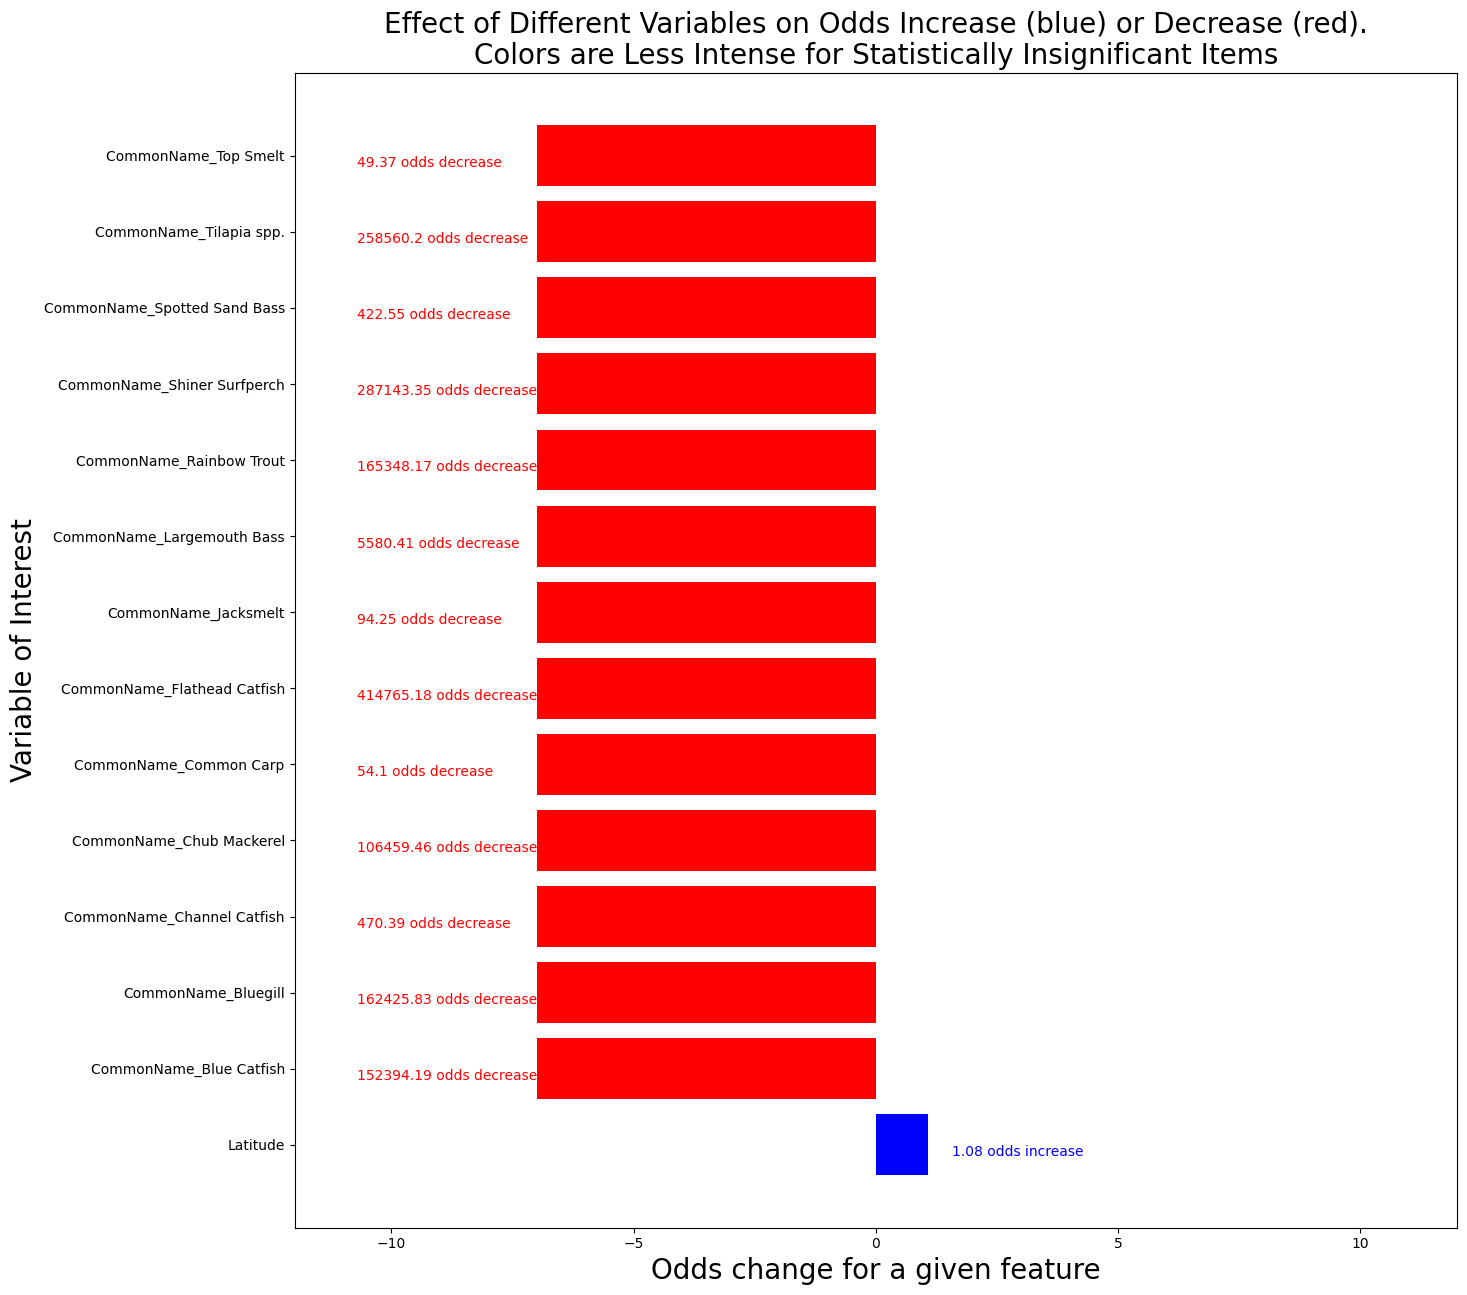

In [26]:


fix, ax = plt.subplots(figsize=(15, 15))

# Clip the bar sizes to a reasonable range
max_bar_size = 7  # Adjust this value as needed
size_clipped = np.clip(size, -max_bar_size, max_bar_size)

ax.barh(categories, size_clipped, color=colors)

for index, bar_size in enumerate(size):
    if (bar_size > 0.0):
        # Add a label text, using clipped size for placement
        ax.text(size_clipped[index] + 0.5, index - 0.15, f'{bar_size} odds increase', color='blue')

        # Add a p-value disclaimer
        if (p_values[index] > 0.05):
            ax.text(-2.5, index - 0.15, f'p-values={p_values[index]}', color='blue')
    else:
        # Label text, using clipped size for placement
        ax.text(size_clipped[index] - 3.7, index - 0.15, f'{abs(bar_size)} odds decrease', color='red')

        # p-value disclaimer
        if (p_values[index] >= 0.05):
            ax.text(0.3, index - 0.15, f'p-values={p_values[index]}', color='red')

# change the limit to make sure labels go inside the plot area
plt.xlim(-max_bar_size -5, max_bar_size + 5)  # Adjusted based on max_bar_size
plt.title('Effect of Different Variables on Odds Increase (blue) or Decrease (red).\
\nColors are Less Intense for Statistically Insignificant Items', size=20)
plt.xlabel('Odds change for a given feature', size=20)
plt.ylabel('Variable of Interest', size=20)
plt.show()

This looks really weird since the only positive coefficient is latitude. Something is at play here. Let's look at the confusion matrix.

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7395
           1       0.95      0.48      0.63       658

    accuracy                           0.95      8053
   macro avg       0.95      0.74      0.80      8053
weighted avg       0.95      0.95      0.95      8053



,Predicted Non-Toxic,Predicted Toxic
True Non-Toxic,7377,18
True Toxic,345,313


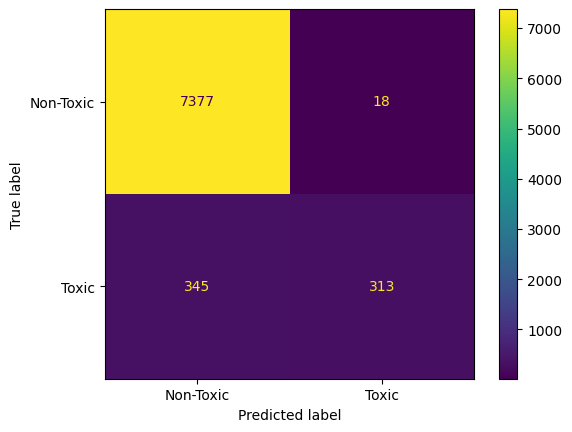

In [27]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification Report
print(classification_report(y_test, y_test_pred_binary))

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred_binary)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Non-Toxic", "Predicted Toxic"],
    index=["True Non-Toxic", "True Toxic"]
)

display(cf_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=["Non-Toxic", "Toxic"])
disp.plot()
plt.show()

The recall score of the model is pretty terrible, as it misidentifies more than 50% of toxic samples as non-toxic.

## SKlearn Baseline Logistic Regression Model

Here I am trying out SKlearn's Logistic Regression and test with different random states, as well as seeing the difference between L1 & L2 regularizations to see if the results improves


First, I am going to fit a simple logistic regression again but this time using Sklearn, using the same X and y as my last model in my previous sprint

## Train/Test Split - Default L1 Penalization, 10 Random States

First Model:

In [28]:
from sklearn.linear_model import LogisticRegression

# 0. Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X3, y_log, test_size=0.2, random_state=14)

# 1. Instantiate model
logistic_regression_model1 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model1_fitted = logistic_regression_model1.fit(X_train1, y_train1)

# 3. Score on the training data
print(logistic_regression_model1.score(X_train1, y_train1))

# 4. Score on the testing data
print(logistic_regression_model1.score(X_test1, y_test1))

0.9539583980130394
0.9582764187259406


Second Model:

In [29]:
# 0. Split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3, y_log, test_size=0.2, random_state=17)

# 1. Instantiate model
logistic_regression_model2 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model2.fit(X_train2, y_train2)

# 3. Score on the training data
print(logistic_regression_model2.score(X_train2, y_train2))

# 4. Score on the testing data
print(logistic_regression_model2.score(X_test2, y_test2))

0.954796647004036
0.9549236309449894


In [30]:
# 0. Split the data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y_log, test_size=0.2, random_state=20)

# 1. Instantiate model
logistic_regression_model3 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model3.fit(X_train3, y_train3)

# 3. Score on the training data
print(logistic_regression_model3.score(X_train3, y_train3))

# 4. Score on the testing data
print(logistic_regression_model3.score(X_test3, y_test3))

0.9552623408879231
0.9530609710666832


In [31]:
# 0. Split the data
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3, y_log, test_size=0.2, random_state=23)

# 1. Instantiate model
logistic_regression_model4 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model4.fit(X_train4, y_train4)

# 3. Score on the training data
print(logistic_regression_model4.score(X_train4, y_train4))

# 4. Score on the testing data
print(logistic_regression_model4.score(X_test4, y_test4))

0.9543930456380006
0.9565379361728549


In [32]:
# 0. Split the data
X_train5, X_test5, y_train5, y_test5 = train_test_split(X3, y_log, test_size=0.2, random_state=26)

# 1. Instantiate model
logistic_regression_model5 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model5.fit(X_train5, y_train5)

# 3. Score on the training data
print(logistic_regression_model5.score(X_train5, y_train5))

# 4. Score on the testing data
print(logistic_regression_model5.score(X_test5, y_test5))

0.9544861844147781
0.9561654041971936


In [33]:
# 0. Split the data
X_train6, X_test6, y_train6, y_test6 = train_test_split(X3, y_log, test_size=0.2, random_state=29)

# 1. Instantiate model
logistic_regression_model6 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model6.fit(X_train6, y_train6)

# 3. Score on the training data
print(logistic_regression_model6.score(X_train6, y_train6))

# 4. Score on the testing data
print(logistic_regression_model6.score(X_test6, y_test6))

0.9542999068612232
0.9569104681485161


In [34]:
# 0. Split the data
X_train7, X_test7, y_train7, y_test7 = train_test_split(X3, y_log, test_size=0.2, random_state=32)

# 1. Instantiate model
logistic_regression_model7 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model7.fit(X_train7, y_train7)

# 3. Score on the training data
print(logistic_regression_model7.score(X_train7, y_train7))

# 4. Score on the testing data
print(logistic_regression_model7.score(X_test7, y_test7))

0.9548587395218876
0.9546752762945486


In [35]:
# 0. Split the data
X_train8, X_test8, y_train8, y_test8 = train_test_split(X3, y_log, test_size=0.2, random_state=35)

# 1. Instantiate model
logistic_regression_model8 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model8.fit(X_train8, y_train8)

# 3. Score on the training data
print(logistic_regression_model8.score(X_train8, y_train8))

# 4. Score on the testing data
print(logistic_regression_model8.score(X_test8, y_test8))

0.955107109593294
0.9536818576927854


In [36]:
# 0. Split the data
X_train9, X_test9, y_train9, y_test9 = train_test_split(X3, y_log, test_size=0.2, random_state=38)

# 1. Instantiate model
logistic_regression_model9 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model9.fit(X_train9, y_train9)

# 3. Score on the training data
print(logistic_regression_model9.score(X_train9, y_train9))

# 4. Score on the testing data
print(logistic_regression_model9.score(X_test9, y_test9))

0.9546724619683328
0.9554203402458711


In [37]:
# 0. Split the data
X_train10, X_test10, y_train10, y_test10 = train_test_split(X3, y_log, test_size=0.2, random_state=41)

# 1. Instantiate model
logistic_regression_model10 = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model10.fit(X_train10, y_train10)

# 3. Score on the training data
print(logistic_regression_model10.score(X_train10, y_train10))

# 4. Score on the testing data
print(logistic_regression_model10.score(X_test10, y_test10))

0.9545172306737039
0.9560412268719731


In [38]:
L1_train_scores = []
for i in range(1, 11):
  model_name = f"logistic_regression_model{i}"
  X_train_name = f"X_train{i}"
  y_train_name = f"y_train{i}"
  L1_train_scores.append(globals()[model_name].score(globals()[X_train_name], globals()[y_train_name]))
L1_train_scores

[0.9539583980130394,
 0.954796647004036,
 0.9552623408879231,
 0.9543930456380006,
 0.9544861844147781,
 0.9542999068612232,
 0.9548587395218876,
 0.955107109593294,
 0.9546724619683328,
 0.9545172306737039]

In [39]:
L1_test_scores = []
for i in range(1, 11):
  model_name = f"logistic_regression_model{i}"
  X_test_name = f"X_test{i}"
  y_test_name = f"y_test{i}"
  L1_test_scores.append(globals()[model_name].score(globals()[X_test_name], globals()[y_test_name]))
L1_test_scores


[0.9582764187259406,
 0.9549236309449894,
 0.9530609710666832,
 0.9565379361728549,
 0.9561654041971936,
 0.9569104681485161,
 0.9546752762945486,
 0.9536818576927854,
 0.9554203402458711,
 0.9560412268719731]

In [40]:
# prompt: print length of train score and test score

print(len(L1_train_scores))
print(len(L1_test_scores))


10
10


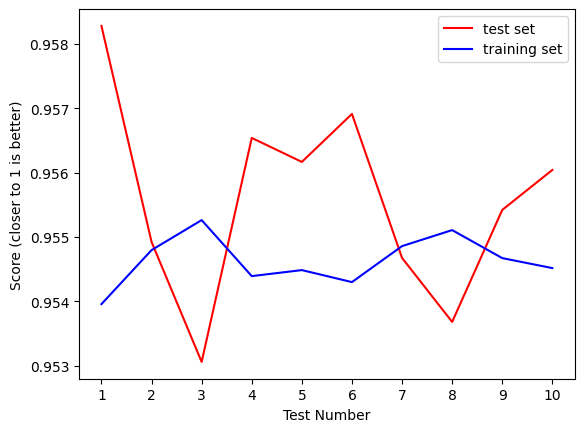

In [41]:

# Plot train/test split


split_range = np.arange(1,11,1)

plt.plot(split_range, L1_test_scores,  color='red',label="test set")
plt.plot(split_range, L1_train_scores, color='blue',label="training set")
plt.xticks(split_range)
plt.ylabel('Score (closer to 1 is better)')
plt.xlabel('Test Number')
plt.legend()
plt.show()

According to the test scores test number 1 with random state 14 has the best performance


## Repeat but with L2

In [42]:
# 0. Split the data
l2_X_train1, l2_X_test1, l2_y_train1, l2_y_test1 = train_test_split(X3, y_log, test_size=0.2, random_state=14)

# 1. Instantiate model
l2_logistic_regression_model1 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model1.fit(l2_X_train1, l2_y_train1)

# 3. Score on the training data
print(l2_logistic_regression_model1.score(l2_X_train1, l2_y_train1))

# 4. Score on the testing data
print(l2_logistic_regression_model1.score(l2_X_test1, l2_y_test1))

0.9539583980130394
0.9582764187259406


In [43]:
# 0. Split the data
l2_X_train2, l2_X_test2, l2_y_train2, l2_y_test2 = train_test_split(X3, y_log, test_size=0.2, random_state=17)

# 1. Instantiate model
l2_logistic_regression_model2 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model2.fit(l2_X_train2, l2_y_train2)

# 3. Score on the training data
print(l2_logistic_regression_model2.score(l2_X_train2, l2_y_train2))

# 4. Score on the testing data
print(l2_logistic_regression_model2.score(l2_X_test2, l2_y_test2))

0.954796647004036
0.9549236309449894


In [44]:
# 0. Split the data
l2_X_train3, l2_X_test3, l2_y_train3, l2_y_test3 = train_test_split(X3, y_log, test_size=0.2, random_state=20)

# 1. Instantiate model
l2_logistic_regression_model3 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model3.fit(l2_X_train3, l2_y_train3)

# 3. Score on the training data
print(l2_logistic_regression_model3.score(l2_X_train3, l2_y_train3))

# 4. Score on the testing data
print(l2_logistic_regression_model3.score(l2_X_test3, l2_y_test3))

0.9552623408879231
0.9530609710666832


In [45]:
# 0. Split the data
l2_X_train4, l2_X_test4, l2_y_train4, l2_y_test4 = train_test_split(X3, y_log, test_size=0.2, random_state=23)

# 1. Instantiate model
l2_logistic_regression_model4 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model4.fit(l2_X_train4, l2_y_train4)

# 3. Score on the training data
print(l2_logistic_regression_model4.score(l2_X_train4, l2_y_train4))

# 4. Score on the testing data
print(l2_logistic_regression_model4.score(l2_X_test4, l2_y_test4))

0.9543930456380006
0.9565379361728549


In [46]:
# 0. Split the data
l2_X_train5, l2_X_test5, l2_y_train5, l2_y_test5 = train_test_split(X3, y_log, test_size=0.2, random_state=26)

# 1. Instantiate model
l2_logistic_regression_model5 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model5.fit(l2_X_train5, l2_y_train5)

# 3. Score on the training data
print(l2_logistic_regression_model5.score(l2_X_train5, l2_y_train5))

# 4. Score on the testing data
print(l2_logistic_regression_model5.score(l2_X_test5, l2_y_test5))

0.9544861844147781
0.9561654041971936


In [47]:
# 0. Split the data
l2_X_train6, l2_X_test6, l2_y_train6, l2_y_test6 = train_test_split(X3, y_log, test_size=0.2, random_state=29)

# 1. Instantiate model
l2_logistic_regression_model6 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model6.fit(l2_X_train6, l2_y_train6)

# 3. Score on the training data
print(l2_logistic_regression_model6.score(l2_X_train6, l2_y_train6))

# 4. Score on the testing data
print(l2_logistic_regression_model6.score(l2_X_test6, l2_y_test6))

0.9542999068612232
0.9569104681485161


In [48]:
# 0. Split the data
l2_X_train7, l2_X_test7, l2_y_train7, l2_y_test7 = train_test_split(X3, y_log, test_size=0.2, random_state=32)

# 1. Instantiate model
l2_logistic_regression_model7 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model7.fit(l2_X_train7, l2_y_train7)

# 3. Score on the training data
print(l2_logistic_regression_model7.score(l2_X_train7, l2_y_train7))

# 4. Score on the testing data
print(l2_logistic_regression_model7.score(l2_X_test7, l2_y_test7))

0.9548587395218876
0.9546752762945486


In [49]:
# 0. Split the data
l2_X_train8, l2_X_test8, l2_y_train8, l2_y_test8 = train_test_split(X3, y_log, test_size=0.2, random_state=35)

# 1. Instantiate model
l2_logistic_regression_model8 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model8.fit(l2_X_train8, l2_y_train8)

# 3. Score on the training data
print(l2_logistic_regression_model8.score(l2_X_train8, l2_y_train8))

# 4. Score on the testing data
print(l2_logistic_regression_model8.score(l2_X_test8, l2_y_test8))

0.955107109593294
0.9536818576927854


In [50]:
# 0. Split the data
l2_X_train9, l2_X_test9, l2_y_train9, l2_y_test9 = train_test_split(X3, y_log, test_size=0.2, random_state=38)

# 1. Instantiate model
l2_logistic_regression_model9 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model9.fit(l2_X_train9, l2_y_train9)

# 3. Score on the training data
print(l2_logistic_regression_model9.score(l2_X_train9, l2_y_train9))

# 4. Score on the testing data
print(l2_logistic_regression_model9.score(l2_X_test9, l2_y_test9))

0.9546724619683328
0.9554203402458711


In [51]:
# 0. Split the data
l2_X_train10, l2_X_test10, l2_y_train10, l2_y_test10 = train_test_split(X3, y_log, test_size=0.2, random_state=41)

# 1. Instantiate model
l2_logistic_regression_model10 = LogisticRegression(penalty='l2', C=0.5, solver = 'lbfgs')

# 2. Fit model on the training data
l2_logistic_regression_model10.fit(l2_X_train10, l2_y_train10)

# 3. Score on the training data
print(l2_logistic_regression_model10.score(l2_X_train10, l2_y_train10))

# 4. Score on the testing data
print(l2_logistic_regression_model10.score(l2_X_test10, l2_y_test10))

0.9545172306737039
0.9560412268719731


In [52]:
L2_train_scores = []
for i in range(1, 11):
  L2_model_name = f"l2_logistic_regression_model{i}"
  L2_X_train_name = f"l2_X_train{i}"
  L2_y_train_name = f"l2_y_train{i}"
  L2_train_scores.append(globals()[L2_model_name].score(globals()[L2_X_train_name], globals()[L2_y_train_name]))
L2_train_scores

[0.9539583980130394,
 0.954796647004036,
 0.9552623408879231,
 0.9543930456380006,
 0.9544861844147781,
 0.9542999068612232,
 0.9548587395218876,
 0.955107109593294,
 0.9546724619683328,
 0.9545172306737039]

In [53]:
L2_test_scores = []
for i in range(1, 11):
  L2_model_name = f"l2_logistic_regression_model{i}"
  L2_X_test_name = f"l2_X_test{i}"
  L2_y_test_name = f"l2_y_test{i}"
  L2_test_scores.append(globals()[L2_model_name].score(globals()[L2_X_test_name], globals()[L2_y_test_name]))
L2_test_scores


[0.9582764187259406,
 0.9549236309449894,
 0.9530609710666832,
 0.9565379361728549,
 0.9561654041971936,
 0.9569104681485161,
 0.9546752762945486,
 0.9536818576927854,
 0.9554203402458711,
 0.9560412268719731]

In [54]:
# prompt: print length of train score and test score

print(len(L2_train_scores))
print(len(L2_test_scores))


10
10


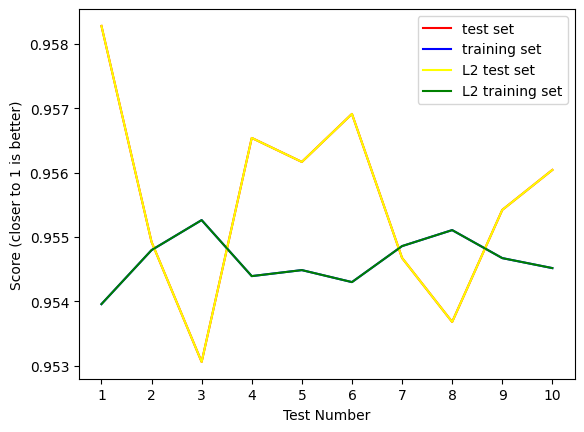

In [55]:

# Plot train/test split


split_range = np.arange(1,11,1)

plt.plot(split_range, L1_test_scores,  color='red',label="test set")
plt.plot(split_range, L1_train_scores, color='blue',label="training set")
plt.plot(split_range, L2_test_scores,  color='yellow',label="L2 test set")
plt.plot(split_range, L2_train_scores, color='green',label="L2 training set")
plt.xticks(split_range)
plt.ylabel('Score (closer to 1 is better)')
plt.xlabel('Test Number')
plt.legend()
plt.show()

It produced the same result that model 1 with random state 14 gave the best test accuracy score. Next, I will use gridsearch to find the best hyperparameter

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

l2_X_train1, l2_X_test1, l2_y_train1, l2_y_test1 = train_test_split(X3, y_log, test_size=0.2, random_state=14)

#we give our estimators as a list of tuples: name:function.
estimators = [('normalise', RobustScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

In [71]:
param_grid = [{
    'model': [LogisticRegression()],
    'normalise':[None, MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['saga', 'liblinear', 'lbfgs'],
    'model__C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy')

In [72]:
fittedgrid = grid.fit(l2_X_train1, l2_y_train1)

In [73]:
print("Best parameters:", fittedgrid.best_params_)
print("Best score:", fittedgrid.best_score_)

Best parameters: {'model': LogisticRegression(), 'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'saga', 'normalise': StandardScaler()}
Best score: 0.9539583980130393


## Model Evaluation

The first metric we will be using to evaluating the accuracy of the model is with the confusion matrix and precision & recall scores.

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7403
           1       0.96      0.51      0.66       650

    accuracy                           0.96      8053
   macro avg       0.96      0.75      0.82      8053
weighted avg       0.96      0.96      0.95      8053



,Predicted Non-Toxic,Predicted Toxic
True Non-Toxic,7388,15
True Toxic,321,329


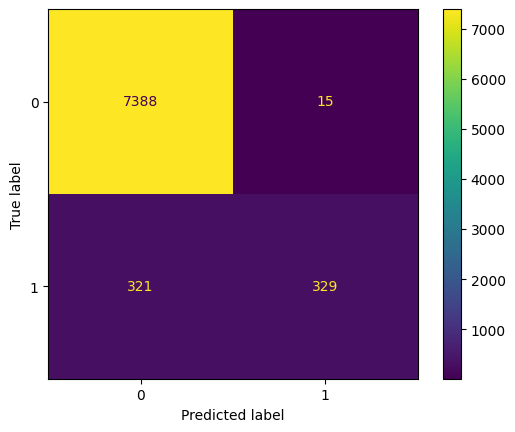

In [74]:
# Access the best estimator
best_log_model = fittedgrid.best_estimator_

# Evaluate the best model on the test set
y_pred = best_log_model.predict(l2_X_test1)

# Print classification report for the best model
print(classification_report(l2_y_test1, y_pred))

#Confusion matrix for the best model
cf_matrix = confusion_matrix(l2_y_test1, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Non-Toxic", "Predicted Toxic"],
    index=["True Non-Toxic", "True Toxic"]
)

display(cf_df)
ConfusionMatrixDisplay.from_estimator(best_log_model, l2_X_test1, l2_y_test1)

The recall sccore is slightly better than the previous base model...however, it is still under the 60% threshold...

Evaluating Model with ROC & AUC Curve

In [75]:
from sklearn.metrics import recall_score

# First calculate the True Positive Rate, which measures what proportion of all positives were correctly classified as positive
y_proba = best_log_model.predict_proba(l2_X_test1)[:,1]
y_binary = np.where(y_proba > 0.5, 1, 0)

TPR = recall_score(l2_y_test1, y_binary)
print(f"TPR: {TPR}")

TPR: 0.5061538461538462


In [76]:
# Then calculate the False Positive Rate, which will be the proportion of all negatives that we incorrectly identified as positive


def false_positive_rate(y_true, y_pred):

    false_positives = (y_true == 0) & (y_pred == 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)

    return FPR

y_proba = best_log_model.predict_proba(l2_X_test1)[:,1]
y_binary = np.where(y_proba > 0.5, 1, 0)

FPR = false_positive_rate(l2_y_test1, y_binary)
print(f"FPR: {FPR}")

FPR: 0.002026205592327435


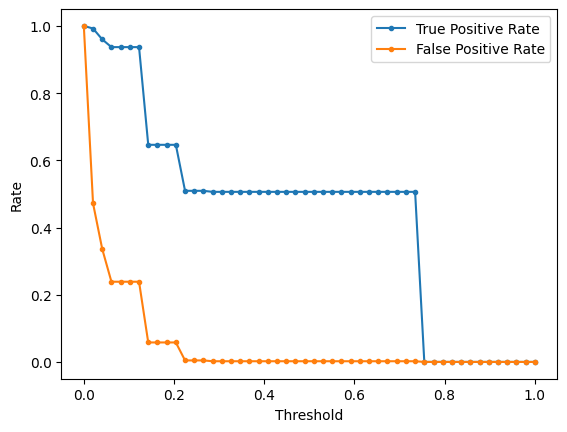

In [78]:
# Iterate over the thresholds and compute the positive and negative recall
true_positive_rates = []
false_positive_rates = []

thresholds = np.linspace(0, 1, 50)
for threshold in thresholds:

    # Apply the cutoff and calculate the positive and negative recall
    y_pred = np.where(y_proba > threshold, 1, 0)

    tpr = recall_score(l2_y_test1, y_pred)
    fpr = false_positive_rate(l2_y_test1, y_pred)

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

plt.figure()
plt.plot(thresholds, true_positive_rates, label='True Positive Rate', marker='.')
plt.plot(thresholds, false_positive_rates, label='False Positive Rate', marker='.')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.show()

Ideally we want a high TPR and a low FPR, which looks like the threshold would be somewhere around 0.15.

Next we plot the ROC curve to l

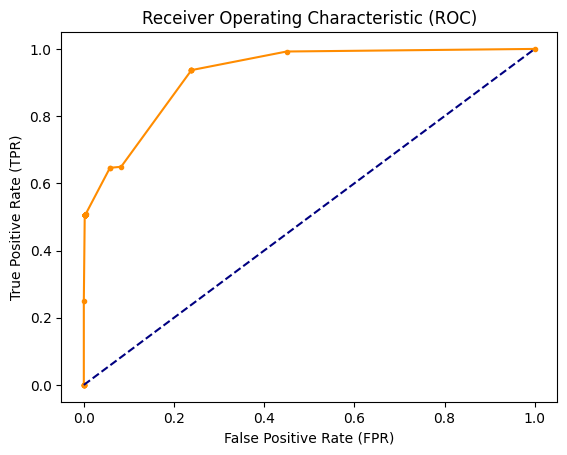

In [66]:
# True positive rate (TPR) = recall
tprs = np.array(true_positive_rates)

# False positive rate (FPR)
fprs = np.array(false_positive_rates)

plt.figure()
plt.plot(fprs, tprs, color='darkorange', marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

Next, we plot the ROC curve with the AUC. The closer the value it is to 1, the better the model is at. The curve shows that if we are will to tolarate a false negative rate of about 0.3, we can expact about 0.91 true positive rate

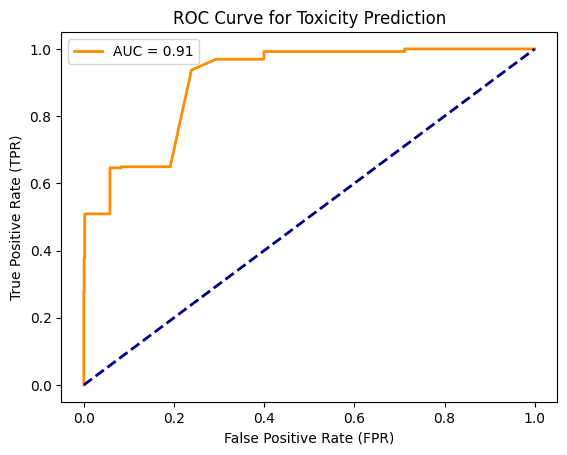

Area under curve (AUC):0.9063147996134624



In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(l2_y_test1, y_proba)
roc_auc = roc_auc_score(l2_y_test1, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Toxicity Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

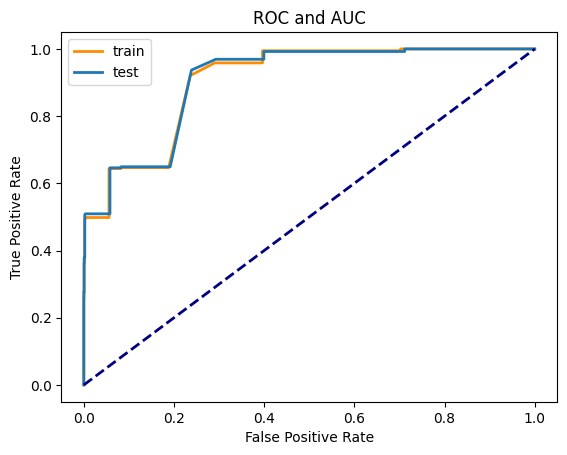

Test AUC score: 0.9063147996134624
Train AUC score: 0.9051541694333549


In [69]:
#Get the probability for each point in the train set.
y_proba_train = l2_logistic_regression_model1.predict_proba(l2_X_train1)[:,1]

# Compute ROC curve and AUC for for the one class
fprs_train, tprs_train, thresholds_train = roc_curve(l2_y_train1, y_proba_train)
roc_auc_train = roc_auc_score(l2_y_train1, y_proba_train)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs, tprs, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print(f"Test AUC score: {roc_auc}")
print(f"Train AUC score: {roc_auc_train}")

Plotting both the AUC for training and test shows that the test score is slightly higher.

The last metric to evaluate is Mean Absolute Error and RMSE	Root Mean Squared Error, the closer the score is to 0, the better the fit the model is.

In [80]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(l2_y_test1, y_pred)
rmse = root_mean_squared_error(l2_y_test1, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.0807152613932696
R2: -0.08780224233418843
RMSE: 0.2841043142813386


## Conclusion

The logistic regression model appears to be a suboptimal choice for this problem set. Upon analyzing the class imbalance in the target variable, I suspect this imbalance is contributing to the model's low recall rate.

To address this, I plan to explore Decision Trees and Random Forest Classifiers, as these models are generally more effective in handling imbalanced classes and are not as impacted by scalability issues. Additionally, the ultimate goal is to either predict locations with the highest PCB levels or incorporate location as an indicator of PCB levels. Random Forest Classifiers, in particular, are widely used in the industry for such tasks and may prove to be a more suitable solution.

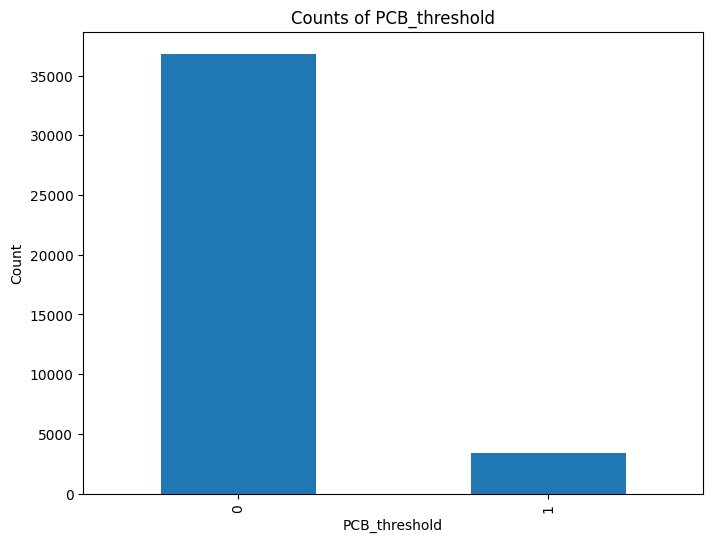

In [82]:

plt.figure(figsize=(8, 6))
PCB_df['PCB_threshold'].value_counts().plot(kind='bar')
plt.title('Counts of PCB_threshold')
plt.xlabel('PCB_threshold')
plt.ylabel('Count')
plt.show()